In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
import numpy as np
import h5py
import datetime
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [3]:
f_train = h5py.File("TrainEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")
f_test = h5py.File("TestEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")

In [4]:
f_train['WhitenedSignals']

<HDF5 dataset "WhitenedSignals": shape (9861, 8192), type "<f8">

In [5]:
np.amax(f_train['m1m2'][...])

75.15116279069767

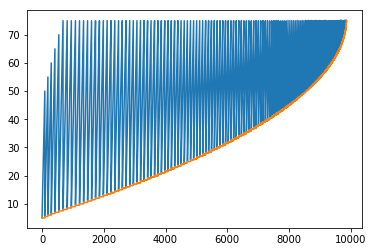

In [6]:
plt.plot(f_train['m1m2'][...].T[0])
plt.plot(f_train['m1m2'][...].T[1])

0:00:15.988060


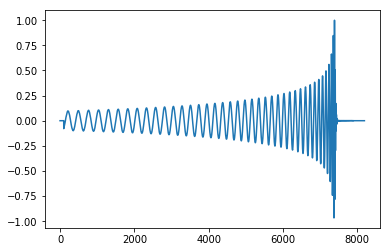

In [7]:
NUM_DATA = f_train['WhitenedSignals'].shape[0]
LENGTH = f_train['WhitenedSignals'].shape[1]
def get_batch(f,k): 
    batch = []
    label = []
    idx = np.arange(NUM_DATA)
    np.random.shuffle(idx)

    num_batch = NUM_DATA//k
    for i in range(num_batch):
        cur_batch = []
        cur_label = []
        for j in range(k):
            cur_batch.append(f['WhitenedSignals'][idx[k*i+j]])
            cur_label.append(f['m1m2'][idx[k*i+j]])
        batch.append(cur_batch)
        label.append(cur_label) 
        
    batch = np.asarray(batch).reshape(num_batch,k,LENGTH,1)
    label = np.asarray(label)
    return batch, label

def get_test(f,k):
    batch = []
    label = []
    idx = np.random.choice(f_test['WhitenedSignals'].shape[0], k, replace=False)

    for i in range(k):
        batch.append(f['WhitenedSignals'][idx[i]])
        label.append(f['m1m2'][idx[i]])

    batch = np.asarray(batch).reshape(k,LENGTH,1)
    label = np.asarray(label)
    return batch, label

start = datetime.datetime.now()
train_data, train_label = get_batch(f_train, 64)
end = datetime.datetime.now()
plt.plot(train_data[0][0])
print(end-start)

In [8]:
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=128,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")

    raw = tf.layers.flatten(raw)

    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 128, False)
    #values = tf.slice(raw, [0,tf.shape(raw)[-1]-512], [-1,-1])
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.1)
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.1)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.1)
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.1)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

1025


In [9]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.01, 
                                           global_step=global_step, 
                                           decay_steps=NUM_DATA, 
                                           decay_rate=0.96, 
                                           staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)#learning_rate)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.


In [10]:
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)
loss_hist = []
val_loss = []
lrs = []
saver.restore(sess, "../model/predictor2.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../model/predictor2.ckpt


In [22]:
num_epoch = 50
start = datetime.datetime.now()
batch_size = 64
rate = 0.0001
for i in range(num_epoch):
    train_data, train_label = get_batch(f_train, batch_size)
    for j in range(len(train_data)):
        cur_data = train_data[j]
        cur_label = train_label[j]
        _, loss_val = sess.run([train_op, loss],
                           feed_dict={input_data: cur_data,
                                      input_label: cur_label,
                                      feedlr: rate})
        loss_hist.append(loss_val)
        if j % 10 == 0:
            print('loss: '+str(loss_hist[-1]))
    
    val_data, val_label = get_test(f_test, batch_size)
    validation = sess.run(loss, feed_dict={input_data: val_data, input_label: val_label})
    val_loss.append(validation)
    print('iter num: '+str(i)+' loss: '+str(loss_hist[-1])+' val_loss: '+str(val_loss[-1]))

end = datetime.datetime.now()
print('time: '+str(end-start))

loss: 1.3414533
loss: 1.1014242
loss: 0.7905977
loss: 0.86288226
loss: 0.6976507
loss: 0.7358544
loss: 0.6652202
loss: 1.6347594
loss: 0.9276905
loss: 0.9521516
loss: 0.74330026
loss: 1.0198905
loss: 0.82294965
loss: 0.5487354
loss: 0.7428181
loss: 0.7353506
iter num: 0 loss: 0.8979894 val_loss: 0.82821107
loss: 0.76838946
loss: 0.6773623
loss: 0.79986966
loss: 0.8407527
loss: 1.0747901
loss: 1.039464
loss: 0.4796602
loss: 0.6741919
loss: 1.4423885
loss: 0.69443405
loss: 0.99839777
loss: 0.583472
loss: 0.5867754
loss: 0.73032814
loss: 0.83346164
loss: 0.8008629
iter num: 1 loss: 0.6330919 val_loss: 0.9059667
loss: 0.65940183
loss: 1.0208042
loss: 0.65422267
loss: 0.9313113
loss: 0.4491326
loss: 0.5695611
loss: 0.7609231
loss: 0.53991574
loss: 0.8516765
loss: 0.7484205
loss: 0.4872424
loss: 0.6357202
loss: 0.62376875
loss: 1.12413
loss: 0.5646181
loss: 0.72007835
iter num: 2 loss: 0.6992118 val_loss: 0.8816643
loss: 0.89528596
loss: 0.59945446
loss: 0.5498384
loss: 0.37478602
loss: 0.88

loss: 0.7611246
loss: 0.54785085
loss: 0.8168125
loss: 1.4271331
loss: 1.0154532
loss: 0.5604142
loss: 1.0982816
loss: 0.7207895
loss: 0.74621034
iter num: 26 loss: 0.9667872 val_loss: 0.851477
loss: 0.6106816
loss: 1.3057855
loss: 0.9054606
loss: 0.57425094
loss: 0.7446117
loss: 1.0291047
loss: 1.5368679
loss: 0.5999299
loss: 0.9664691
loss: 0.88619417
loss: 0.69122887
loss: 0.5222837
loss: 0.7636826
loss: 0.7153417
loss: 0.67479515
loss: 0.98291016
iter num: 27 loss: 0.6860551 val_loss: 0.61950296
loss: 0.7160751
loss: 1.0550673
loss: 0.8637455
loss: 0.97110885
loss: 0.6275175
loss: 1.0311784
loss: 0.5012782
loss: 0.6539211
loss: 0.9831606
loss: 1.1937335
loss: 0.929971
loss: 0.59743315
loss: 0.473606
loss: 0.83614326
loss: 0.82440656
loss: 0.4605825
iter num: 28 loss: 0.45779285 val_loss: 0.56680524
loss: 0.7702187
loss: 0.5718876
loss: 0.71730417
loss: 1.1726913
loss: 0.55193096
loss: 0.5490174
loss: 0.7078931
loss: 0.6414062
loss: 0.7936924
loss: 0.65290534
loss: 0.58941483
loss: 

In [21]:
##predictor2
interval = [[0,int(8192*0.2)],[0,int(8192*0.4)],[0,int(8192*0.6)],[0,int(8192*0.8)],[0,8192],
            [int(8192*0.2),int(8192*0.4)],[int(8192*0.2),int(8192*0.6)],[int(8192*0.2),int(8192*0.8)],[int(8192*0.2),8192],
            [int(8192*0.4),int(8192*0.6)],[int(8192*0.4),int(8192*0.8)],[int(8192*0.4),8192],
            [int(8192*0.6),int(8192*0.8)],[int(8192*0.6),8192],
            [int(8192*0.8),8192]]

for idx in range(len(interval)):
    start = interval[idx][0]
    end = interval[idx][1]
    pred = []
    for i in range(len(f_test['WhitenedSignals'])):
        test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
        test_label = f_test['m1m2'][i].reshape(1,2)
        pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
    pred = np.asarray(pred)
    test_label = np.asarray(f_test['m1m2'])
    m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
    m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
    print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 0 end: 1638 -- m1: 23.9912570039728 m2: 40.99791971480955
start: 0 end: 3276 -- m1: 22.827422499854094 m2: 38.86856485491362
start: 0 end: 4915 -- m1: 21.226175388608326 m2: 35.79156318657103
start: 0 end: 6553 -- m1: 17.34658663487308 m2: 28.2444994398809
start: 0 end: 8192 -- m1: 0.017971632920900225 m2: 0.036700646204456656
start: 1638 end: 3276 -- m1: 23.26973053186224 m2: 39.673041487773936
start: 1638 end: 4915 -- m1: 21.244709392801177 m2: 35.81901804655046
start: 1638 end: 6553 -- m1: 17.34658663487308 m2: 28.2444994398809
start: 1638 end: 8192 -- m1: 0.017971632920900225 m2: 0.036700646204456656
start: 3276 end: 4915 -- m1: 21.932057254995364 m2: 37.21664240649712
start: 3276 end: 6553 -- m1: 17.352245747319927 m2: 28.257971431519824
start: 3276 end: 8192 -- m1: 0.017971632920900225 m2: 0.036700646204456656
start: 4915 end: 6553 -- m1: 18.487770873585994 m2: 30.50532413345911
start: 4915 end: 8192 -- m1: 0.017971632920900225 m2: 0.036700646204456656
start: 6553 end: 819

In [10]:
for idx in range(56):
    start = 5500+idx*10
    end = start+1638
    pred = []
    for i in range(len(f_test['WhitenedSignals'])):
        test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
        test_label = f_test['m1m2'][i].reshape(1,2)
        pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
    pred = np.asarray(pred)
    test_label = np.asarray(f_test['m1m2'])
    m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
    m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
    print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 5500 end: 7138 -- m1: 8.042167948831601 m2: 10.160517719251686
start: 5510 end: 7148 -- m1: 7.584564266651248 m2: 9.502364676627252
start: 5520 end: 7158 -- m1: 7.120055897498769 m2: 8.840756465364374
start: 5530 end: 7168 -- m1: 6.619987865697084 m2: 8.15232549692187
start: 5540 end: 7178 -- m1: 6.058510029364676 m2: 7.4075025746912
start: 5550 end: 7188 -- m1: 5.4974360826900535 m2: 6.671469152904589
start: 5560 end: 7198 -- m1: 4.973843353977612 m2: 6.0022876248753745
start: 5570 end: 7208 -- m1: 4.4628112920925505 m2: 5.3608363725565065
start: 5580 end: 7218 -- m1: 3.9550342434043246 m2: 4.761737333986957
start: 5590 end: 7228 -- m1: 3.4605367874124133 m2: 4.187932435159617
start: 5600 end: 7238 -- m1: 3.014990588363327 m2: 3.665393210186983
start: 5610 end: 7248 -- m1: 2.578315374448804 m2: 3.1687426556403544
start: 5620 end: 7258 -- m1: 2.1677190066074363 m2: 2.7058653281617135
start: 5630 end: 7268 -- m1: 1.7994102785243387 m2: 2.295547584739068
start: 5640 end: 7278 -- m

In [17]:
for idx in range(10):
    start = 5755+idx
    end = start+1802
    pred = []
    for i in range(len(f_test['WhitenedSignals'])):
        test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
        test_label = f_test['m1m2'][i].reshape(1,2)
        pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
    pred = np.asarray(pred)
    test_label = np.asarray(f_test['m1m2'])
    m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
    m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
    print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 5755 end: 7557 -- m1: 0.018009527071521137 m2: 0.037067696142148526
start: 5756 end: 7558 -- m1: 0.01800816597119594 m2: 0.03706246492580683
start: 5757 end: 7559 -- m1: 0.01800548375262674 m2: 0.03706569163380194
start: 5758 end: 7560 -- m1: 0.01799944954375405 m2: 0.03706981784735681
start: 5759 end: 7561 -- m1: 0.017993738740246016 m2: 0.037081314782564316
start: 5760 end: 7562 -- m1: 0.0179936206723375 m2: 0.03707627236866923
start: 5761 end: 7563 -- m1: 0.017993595633620664 m2: 0.037070486908311884
start: 5762 end: 7564 -- m1: 0.01799361830526207 m2: 0.037064109181852205
start: 5763 end: 7565 -- m1: 0.017993958480305525 m2: 0.037055571133769186
start: 5764 end: 7566 -- m1: 0.01799472696239742 m2: 0.037054720351023966


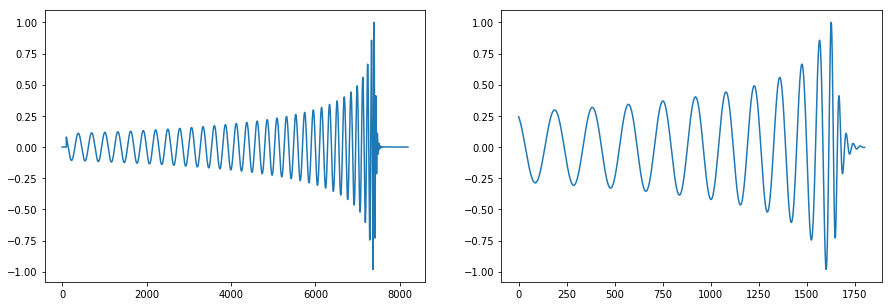

In [44]:
idx = 100
start = 5761
end = 7563
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(f_test['WhitenedSignals'][idx])
plt.subplot(122)
plt.plot(f_test['WhitenedSignals'][idx][start:end])

In [11]:
start = 5761
end = 7563
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 5761 end: 7563 -- m1: 0.017993595633620664 m2: 0.037070486908311884


Text(0.5, 1.0, 'm2 RE with 0.7s to 0.9s input')

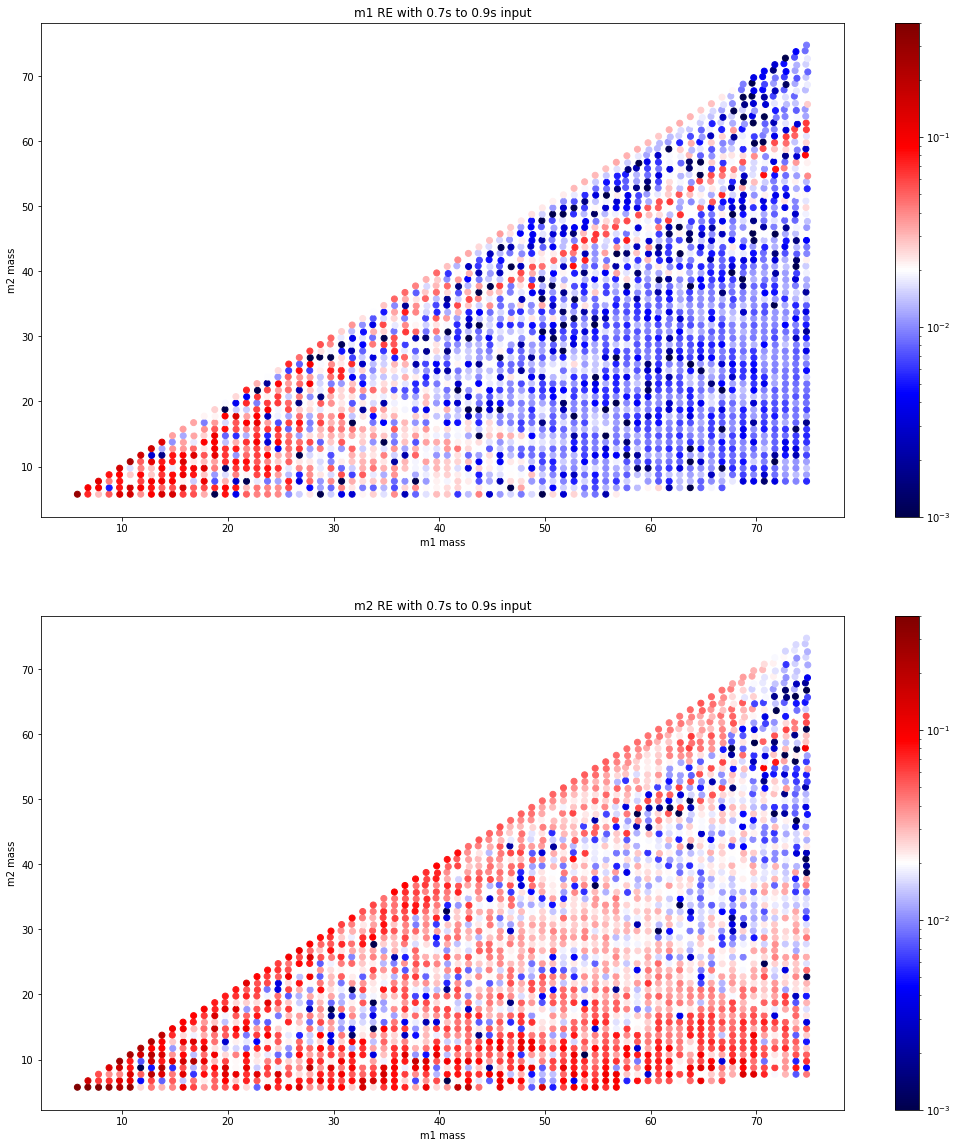

In [39]:
error1 = [abs(pred.T[0][i]-test_label.T[0][i])/test_label.T[0][i] for i in range(len(test_label))]
error2 = [abs(pred.T[1][i]-test_label.T[1][i])/test_label.T[1][i] for i in range(len(test_label))]
plt.figure(figsize=(18,20))
cm = plt.cm.get_cmap('seismic')
plt.subplot(211)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error1, vmin=0.001, vmax=0.4, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error1), vmax=np.amax(error1)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m1 RE with 0.7s to 0.9s input')
plt.subplot(212)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error2, vmin=0.001, vmax=0.4, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error2), vmax=np.amax(error2)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m2 RE with 0.7s to 0.9s input')

In [33]:
##predictor2
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    start = 5500
    end = 7700
    test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('m1: '+str(m1)+'\nm2: '+str(m2))

m1: 0.017962955278887256
m2: 0.036627757059974946


In [23]:
##predictor
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    test_data = f_test['WhitenedSignals'][i].reshape(1,LENGTH,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('m1: '+str(m1)+'\nm2: '+str(m2))

m1: 0.02611287549873274
m2: 0.03855143531068765


In [23]:
save_path = saver.save(sess, "../model/predictor2.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/predictor2.ckpt


Text(0.5, 1.0, 'loss and accuracy')

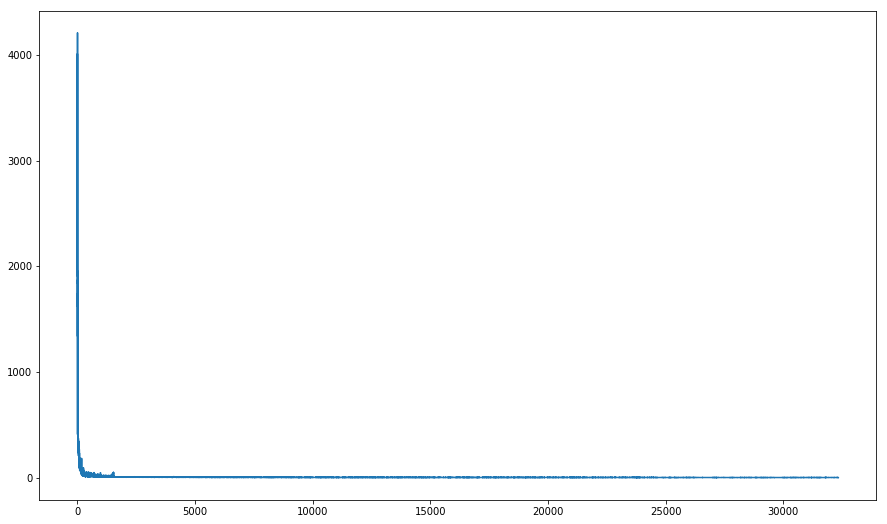

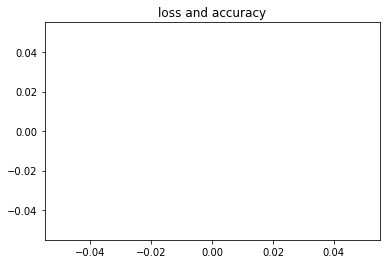

In [24]:
start = 0
length = len(loss_hist) - start
plt.figure(figsize=(15,9))
plt.plot(loss_hist[start:],zorder=1)
#plt.scatter(np.arange(length, step=length//len(val_loss)),val_loss,c='red',zorder=2)
plt.figure()
#plt.plot(lrs[start:])
plt.title('loss and accuracy')

In [22]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 

conv1d/kernel:0 [[[ 0.02820369 -0.38729772  0.04878606  0.25884926  0.05906931
   -0.22070795 -0.30404347  0.436573   -0.0224342   0.36892918
   -0.02169633 -0.18246979 -0.00387169 -0.02663426  0.40235683
   -0.11401626]]

 [[-0.02883411  0.16698271  0.3489708   0.1196642   0.33593196
   -0.01394439  0.26637995 -0.37206632  0.16070996 -0.09476986
   -0.09598011 -0.18586497 -0.23128101  0.24714074  0.21544662
   -0.3729777 ]]]
conv1d/bias:0 [-0.00037455  0.08678375 -0.08123148 -0.11365752 -0.13704954  0.08881047
  0.01374818 -0.02558803 -0.05813484 -0.06711501  0.04992128  0.12440601
  0.0852386  -0.08536495 -0.1516853   0.09682617]
conv1d_1/kernel:0 [[[ 0.06004137  0.17041297 -0.05311629 ... -0.04041095 -0.042399
    0.1327065 ]
  [ 0.09940804 -0.04448859  0.07708742 ...  0.18659261  0.16913103
   -0.2045019 ]
  [-0.27516907 -0.10897405 -0.09842873 ...  0.00391032 -0.24263145
    0.11776425]
  ...
  [ 0.2624147   0.2067342  -0.13544968 ... -0.16012113  0.12073392
   -0.03144623]
  [-0.

conv1d_28/kernel:0 [[[ 2.25515962e-01  2.42472231e-01  1.54564366e-01  1.80548891e-01
    2.32083183e-02 -2.11518303e-01  1.95236623e-01  5.34491874e-02
    2.99529701e-01 -3.91612732e-04 -2.36575887e-01 -3.50285411e-01
    1.51133657e-01 -6.28802255e-02 -7.86969289e-02  1.48800742e-02]
  [-3.89814436e-01 -2.56683707e-01  3.72953475e-01 -4.51116145e-01
   -9.33193937e-02 -3.00187618e-01 -4.17218000e-01 -1.25236258e-01
    2.96711903e-02 -3.61065231e-02  2.03724176e-01  2.74080783e-01
   -9.75212231e-02  1.88108847e-01  2.56018877e-01 -8.12617019e-02]
  [ 2.88212925e-01  1.54768884e-01  2.44688123e-01  1.43895432e-01
    4.52632122e-02 -2.45523602e-01 -3.12145740e-01  1.20589346e-01
   -1.69837281e-01  1.14197351e-01 -3.98851901e-01 -1.90433159e-01
   -1.75285921e-01 -3.05075794e-01 -5.25231004e-01  2.86384165e-01]
  [ 2.29257181e-01  7.27381231e-03  3.40476215e-01  2.35942192e-02
    9.91945714e-03  4.12761837e-01  6.57702163e-02 -2.66629279e-01
    6.32901639e-02  3.44090432e-01 -5.08

In [ ]:
##predictor model
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=32,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")

    raw = tf.layers.flatten(raw)

    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 512, False)
    #values = tf.slice(raw, [0,tf.shape(raw)[-1]-512], [-1,-1])
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.2)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()